<a href="https://colab.research.google.com/github/alexkneifel/353_colab_datacreation_and_nn/blob/main/353NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import math
import numpy as np
import re
import string
import os
import cv2 as cv
from google.colab.patches import cv2_imshow

from collections import Counter
from matplotlib import pyplot as plt

import random
from random import randint
from PIL import Image, ImageFont, ImageDraw, ImageOps

from os import pathconf

#from tensorflow.keras.preprocessing import image


In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [17]:
path = "/content/drive/MyDrive/LicensePlateData/"
print(path)

plates = os.listdir(path)
plates.remove(".ipynb_checkpoints")
print(len(plates))

/content/drive/MyDrive/LicensePlateData/
285


In [35]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# This function gets the image from the file of images, grayscales and applies a first adaptive thresholding
# It then erodes and dilates the photo
# Input: plate num = the index of the platenumber wanted from the file
# Returns: img_dilation = the dilated image, 
#          img_gray  =   the grayscale image, 
#          char1,char2,num1,num2 = the four char labels from the plate

def choosePlate(platenum):
  img_gray = cv.imread(path+plates[platenum], 0)
  thresh = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY, 107, 22)

  kernel1 = np.ones((2,2), np.uint8)
  img_erosion = cv.erode(thresh, kernel1, iterations=1)
  img_dilation = cv.dilate(img_erosion, kernel1, iterations=1)

  #print(sum(sum(img_dilation)))
  #print(plates[platenum])
  #print(str(thresh.shape[0]) + " " + str(thresh.shape[1]))
  # cv2_imshow(img_gray)
  #cv2_imshow(img_dilation)
  char1, char2, num1, num2 = returnLabel(plates[platenum])
  return img_dilation, img_gray, char1,char2,num1,num2

This block gets rid of the side bar

In [19]:
# This function removes the left hand side vertical bar that is 
# present on all the license plates. Not currently in use.
# Input: img_dilation = a black and white license plate image from simulation
# Returns: crop = The same image without the vertical bar on the left
def crop_side_bar(img_dilation):
  max_area = 0
  contours = cv.findContours(img_dilation, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  for c in contours:
    area = cv.contourArea(c)
    if area > max_area:
      max_c = c
      max_area = area

  if max_c is not None:
    leftmost = tuple(max_c[max_c[:, :, 0].argmin()][0])
    rightmost = tuple(max_c[max_c[:, :, 0].argmax()][0])
    top = tuple(max_c[max_c[:, :, 1].argmin()][0])
    bot = tuple(max_c[max_c[:, :, 1].argmax()][0])
    small_leftp = int(leftmost[0])
    small_rightp = int(rightmost[0])
    small_topp = int(top[1])
    small_botp = int(bot[1])

    crop = img_dilation[small_topp:small_botp, small_leftp:small_rightp]
    return crop

In [32]:
# Helper method for finding contours of chars in four photo return method
# Input: img_dilation = the black and white plate, 
#        img_gray = gray plate, 
#         x_shift, y_shift = amt of x and y shift for the crop  (for data augmentation)
# Returns: organized_chars = images of the chars in the order which they appear on the plate,
#          flipd_img = bitwise not image of the black and white inputted

def find_chars(img_dilation,img_gray, x_shift, y_shift):
  count = 0
  order_of_chars = {}
  crops = {}
  flipd_img = cv.bitwise_not(img_dilation)
  #cv2_imshow(flipd_img)
  width = flipd_img.shape[1]
  max_area = 0
  contours = cv.findContours(flipd_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  cnt = sorted(contours, key=cv.contourArea, reverse=True)
  for max_c in contours:
    leftmost = tuple(max_c[max_c[:, :, 0].argmin()][0])
    rightmost = tuple(max_c[max_c[:, :, 0].argmax()][0])
    top = tuple(max_c[max_c[:, :, 1].argmin()][0])
    bot = tuple(max_c[max_c[:, :, 1].argmax()][0])
    if leftmost[0]-5 >0 and top[1] - 5 > 0:
      small_leftp = int(leftmost[0]-5)
      small_rightp = int(rightmost[0]+5)
      small_topp = int(top[1]-5)
      small_botp = int(bot[1]+5)
      # making minimum size of bounding box a square
      if small_rightp - small_leftp < small_botp-small_topp:
        diff = (small_botp-small_topp) - (small_rightp - small_leftp)
        small_leftp = small_leftp - ceildiv(diff,2)
        small_rightp = small_rightp + (diff//2)
      # if including middle thing, cut it in half
      crop_width = small_rightp-small_leftp
      if 0.42 < small_leftp/width <0.455 and crop_width < 60:
        small_leftp = small_leftp + int((crop_width)/2)
      crop = img_gray[small_topp+y_shift:small_botp+y_shift, small_leftp+x_shift:small_rightp+x_shift]
      if crop.shape[1]/float(crop.shape[0]) >= 1:
        order_of_chars.update({count: small_leftp})
        crops.update({count: crop})
        count = count + 1

  # print("map of count to left points: "+ str(order_of_chars))
  # print("map of count to crop: "+ str(crops))

  for image in list(crops.keys()):
    if crops[image].shape[0] < 18:
      crops.pop(image)

  four_points = []
  # this is four largest chars in reverse order
  chars = dict(sorted(crops.items(),key=lambda kv: kv[1].size, reverse=True)[:4])

  for count1, char in chars.items():
    for count2, point in order_of_chars.items():
      if count1 == count2:
        four_points.append(point)

  zip_iterator = zip(four_points, chars.values())
  chars_dict = dict(zip_iterator)
  organized_chars_map = dict(sorted(chars_dict.items(),key=lambda kv: kv[0]))
  organized_chars = list(organized_chars_map.values())

  return organized_chars,flipd_img

def ceildiv(a, b):
    return -(a // -b)


In [39]:
# Main method that calls other helper methods above with the goal to 
# separate the four chars into four clean photos along with their respective labels.
# Input: plate = the color version of the plate from the file,  
#         x_shift, y_shift = amt of x and y shift for the crop  (for data augmentation)
# Returns: first_char,second_char, first_num, second_num  = images of the chars in the order which they appear on the plate,
#          char1,char2,num1,num2 = corresponding labels

def four_photo_return(plate, x_shift, y_shift):
  two_split = False
  # print("plate num: " + str(plate))
  dilate,gray,char1,char2,num1,num2 = choosePlate(plate)
  chars,flipd_img = find_chars(dilate, gray, x_shift, y_shift)
  plate_chars = []

  if sum(sum(flipd_img)) > 26000:
    for i in range(4):
      if chars[i].shape[1]/float(chars[i].shape[0]) > 1.455:
        kernel1 = np.ones((2,2), np.uint8)
        two_dilate = cv.dilate(dilate, kernel1, iterations=1)
        chars, flipd_img = find_chars(two_dilate, gray, x_shift, y_shift)
        # print("extra dilation")
        break
  

  for i in range(len(chars)):
    height = chars[i].shape[0]
    width = chars[i].shape[1]
    if width/float(height) > 2.65:
      # print("pre-3 split")
      plate_chars.append(chars[i][:height, int((0.333)*width):int((0.666)*width)])
      plate_chars.append(chars[i][:height, int((0.666)*width):width])
    elif width/float(height) > 1.55:
      # print("pre-2 split")
      two_split = True
      plate_chars.append(chars[i][:height, 0:int((0.5)*width)])
      plate_chars.append(chars[i][:height, int((0.5)*width):width])
    else:
      plate_chars.append(chars[i])

  if len(plate_chars) == 5 and two_split:
    min_val = plate_chars[4].size
    min_index = 4
    for i in range(4):
      if plate_chars[i].size < min_val:
        min_val =plate_chars[i].size
        min_index = i
    plate_chars.pop(min_index)
  
  first_char = cv.resize(plate_chars[0], (26,22), interpolation = cv.INTER_AREA)
  second_char = cv.resize(plate_chars[1], (26,22), interpolation = cv.INTER_AREA)
  first_num = cv.resize(plate_chars[2], (26,22), interpolation = cv.INTER_AREA)
  second_num = cv.resize(plate_chars[3], (26,22), interpolation = cv.INTER_AREA)

  # cv2_imshow(first_char)
  # cv2_imshow(second_char)
  # cv2_imshow(first_num)
  # cv2_imshow(second_num)

  return first_char,second_char, first_num, second_num, char1,char2,num1,num2



  # cv2_imshow(first_char)
  # print("height: " + str(first_char.shape[0]))
  # print("width: " + str(first_char.shape[1]))
  # print("")
  # cv2_imshow(second_char)
  # print("height: " + str(second_char.shape[0]))
  # print("width: " + str(second_char.shape[1]))
  # print("")
  # cv2_imshow(first_num)
  # print("height: " + str(first_num.shape[0]))
  # print("width: " + str(first_num.shape[1]))
  # print("")
  # cv2_imshow(second_num)
  # print("height: " + str(second_num.shape[0]))
  # print("width: " + str(second_num.shape[1]))
  # print("")

In [22]:
#This returns the label of plate
def returnLabel(string):
    string1,letters,nums = re.split('_', string)
    # print(string1)
    # print(letters)
    # print(nums)
    char1 = letters[0]
    char2 = letters[1]
    num1 = nums[0]
    num2 = nums[1]
    return char1,char2,num1,num2

In [23]:
def asciitoindex(character):
  if ord(character) - 65 >= 0:
    return ord(character)-65 
  else:
    return ord(character)- 48

In [24]:
# This creates the labelled hot encode arrays and the corresponding array of char images
# It also creates the augmented data set, in a char array and num array, with shifts right, left, up and down
# It also graph the spread of input data to the NN (commented code)

def arrays_for_nn():
  countTrainingSet = {"A" : 0, "B" : 0, "C" : 0, "D" : 0, "E" : 0, "F" : 0, "G" : 0, "H" : 0, "I" :0, "J" : 0, "K" :0, 
                      "L" :0, "M" :0, "N" :0, "O" :0, "P" :0, "Q" : 0, "R" :0, "S" :0, "T" :0, "U" :0, "V" :0, "W" : 0, "X" : 0, "Y" :0,
                      "Z": 0, "0" : 0 , "1" : 0,"2" : 0,"3" : 0, "4" : 0, "5": 0, "6":0, "7": 0, "8": 0, "9":0}
  charArray = []
  charEncodeArray = []
  numArray = []
  numEncodeArray = []
  x_shift = 0
  y_shift = 0
  x = [-5,-4,-3,-2,-1,0,1,2,3,4]
  y = [-1,1,2,3]
  for plate in range(285):
    for x_shift in x:
      first_char,second_char, first_num, second_num, char1,char2,num1,num2 = four_photo_return(plate, x_shift, y_shift)
      charArray.append(first_char)
      zeroArray = np.zeros(26)
      zeroArray[asciitoindex(char1)] = 1
      charEncodeArray.append(zeroArray)

      charArray.append(second_char)
      zeroArray = np.zeros(26)
      zeroArray[asciitoindex(char2)] = 1
      charEncodeArray.append(zeroArray)

      numArray.append(first_num)
      zeroArray = np.zeros(10)
      zeroArray[asciitoindex(num1)] = 1
      numEncodeArray.append(zeroArray)

      numArray.append(second_num)
      zeroArray = np.zeros(10)
      zeroArray[asciitoindex(num2)] = 1
      numEncodeArray.append(zeroArray)

      # for letter in countTrainingSet.keys():
      #   if char1 == letter:
      #     countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
      #   if char2 == letter:
      #     countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
      #   if num1 == letter:
      #     countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
      #   if num2 == letter:
      #     countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
    
    x_shift = 0
    for y_shift in y:
      first_char,second_char, first_num, second_num, char1,char2,num1,num2 = four_photo_return(plate, x_shift, y_shift)
      charArray.append(first_char)
      zeroArray = np.zeros(26)
      zeroArray[asciitoindex(char1)] = 1
      charEncodeArray.append(zeroArray)

      charArray.append(second_char)
      zeroArray = np.zeros(26)
      zeroArray[asciitoindex(char2)] = 1
      charEncodeArray.append(zeroArray)

      numArray.append(first_num)
      zeroArray = np.zeros(10)
      zeroArray[asciitoindex(num1)] = 1
      numEncodeArray.append(zeroArray)

      numArray.append(second_num)
      zeroArray = np.zeros(10)
      zeroArray[asciitoindex(num2)] = 1
      numEncodeArray.append(zeroArray)

  #     for letter in countTrainingSet.keys():
  #       if char1 == letter:
  #         countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
  #       if char2 == letter:
  #         countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
  #       if num1 == letter:
  #         countTrainingSet.update({letter: countTrainingSet.get(letter)+1})
  #       if num2 == letter:
  #         countTrainingSet.update({letter: countTrainingSet.get(letter)+1})

  # plt.bar(countTrainingSet.keys(), countTrainingSet.values(), 5)
  return charArray, charEncodeArray, numArray, numEncodeArray
# print(len(charArray))
# print(len(charEncodeArray))
# print(len(numArray))
# print(len(numEncodeArray))
# for char in charArray:
#   cv2_imshow(char)
# print(charEncodeArray)
# for num in numArray:
#   cv2_imshow(num)
# print(numEncodeArray)
  

NEURAL NETWORK FOR CHARS THEN NUMS


In [25]:
# neural net validation split 0.2
VALIDATION_SPLIT = 0.2
%tensorflow_version 1.14.0

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [26]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

Char NN


In [33]:
char_model = models.Sequential()
char_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(26,22,1)))
char_model.add(layers.MaxPooling2D((2, 2)))
char_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
char_model.add(layers.MaxPooling2D((2, 2)))
char_model.add(layers.Flatten())
char_model.add(layers.Dropout(0.5))
char_model.add(layers.Dense(512, activation='relu'))
char_model.add(layers.Dense(26, activation='softmax'))
char_model.summary()

# this model was no good

# char_model = models.Sequential()
# char_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(26, 22, 1)))
# char_model.add(layers.MaxPooling2D((2, 2)))
# char_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# char_model.add(layers.MaxPooling2D((2, 2)))
# char_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# char_model.add(layers.MaxPooling2D((2, 2)))
# char_model.add(layers.Conv2D(128, (1, 1), activation='relu'))
# char_model.add(layers.MaxPooling2D((1, 1)))
# char_model.add(layers.Flatten())
# char_model.add(layers.Dropout(0.5))
# char_model.add(layers.Dense(512, activation='relu'))
# char_model.add(layers.Dense(26, activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 20, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 8, 64)         18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [37]:
LEARNING_RATE = 1e-4
char_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [38]:
reset_weights(char_model)
charArray, charEncodeArray, numArray, numEncodeArray = arrays_for_nn()
print(len(charArray))
charArray = np.asarray(charArray)
charEncodeArray = np.asarray(charEncodeArray)
charArray = charArray.reshape((-1, 26, 22, 1))

history_conv_chars = char_model.fit(charArray, charEncodeArray, 
                              validation_split=VALIDATION_SPLIT,
                              epochs=30, 
                              batch_size=100)

7980
Train on 6384 samples, validate on 1596 samples
Epoch 1/30
6384/6384 [==============================] - 5s 831us/sample - loss: 9.7280 - acc: 0.0570 - val_loss: 3.0044 - val_acc: 0.2093
Epoch 2/30
6384/6384 [==============================] - 5s 756us/sample - loss: 2.8147 - acc: 0.2461 - val_loss: 2.0034 - val_acc: 0.4893
Epoch 3/30
6384/6384 [==============================] - 5s 759us/sample - loss: 1.8198 - acc: 0.5070 - val_loss: 1.3292 - val_acc: 0.6654
Epoch 4/30
6384/6384 [==============================] - 5s 761us/sample - loss: 1.2884 - acc: 0.6493 - val_loss: 0.9489 - val_acc: 0.7763
Epoch 5/30
6384/6384 [==============================] - 5s 768us/sample - loss: 0.9408 - acc: 0.7549 - val_loss: 0.7039 - val_acc: 0.8365
Epoch 6/30
6384/6384 [==============================] - 6s 889us/sample - loss: 0.7152 - acc: 0.8050 - val_loss: 0.5524 - val_acc: 0.8709
Epoch 7/30
6384/6384 [==============================] - 8s 1ms/sample - loss: 0.5619 - acc: 0.8520 - val_loss: 0.4476 -

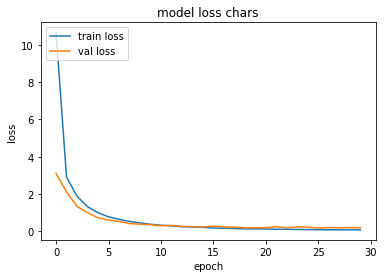

In [ ]:
plt.plot(history_conv_chars.history['loss'])
plt.plot(history_conv_chars.history['val_loss'])
plt.title('model loss chars')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

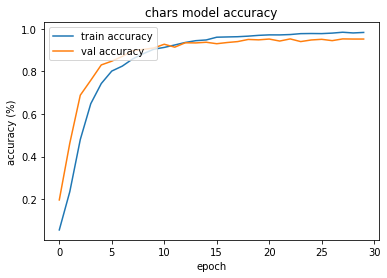

In [ ]:
plt.plot(history_conv_chars.history['acc'])
plt.plot(history_conv_chars.history['val_acc'])
plt.title('chars model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

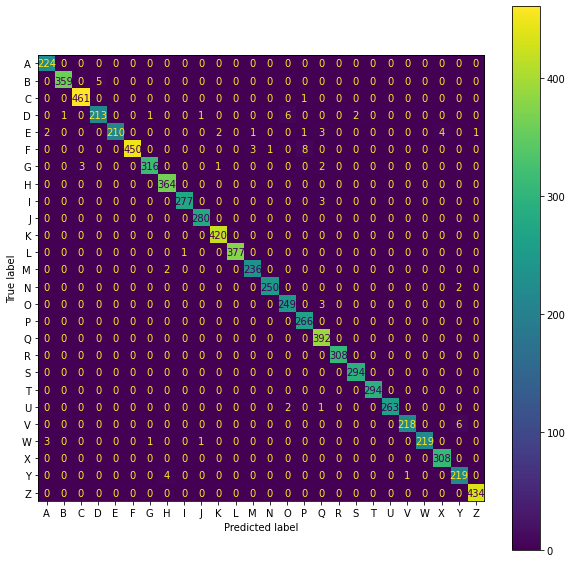

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
true = charEncodeArray
true_char = [characters[np.argmax(i)] for i in true]

predicted = char_model.predict(charArray)
predicted_char = [characters[np.argmax(i)] for i in predicted]

cm = confusion_matrix(true_char, predicted_char, labels=list(characters))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(characters))

fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()

In [ ]:

#!pip install h5py==2.10.0 --force-reinstall

In [ ]:
char_model.save('char_nn')

Number NN

In [ ]:
num_model= models.Sequential()
num_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(26,22,1)))
# size of image
num_model.add(layers.MaxPooling2D((2, 2)))
num_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
num_model.add(layers.MaxPooling2D((2, 2)))
num_model.add(layers.Flatten())
num_model.add(layers.Dropout(0.5))
num_model.add(layers.Dense(512, activation='relu'))
num_model.add(layers.Dense(10, activation='softmax'))
num_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 20, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 8, 64)         18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [ ]:
LEARNING_RATE = 1e-4
num_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [ ]:
reset_weights(num_model)
charArray2, charEncodeArray2, numArray2, numEncodeArray2 = arrays_for_nn()
print(len(numArray2))
numArray2 = np.asarray(numArray2)
numEncodeArray2 = np.asarray(numEncodeArray2)
numArray2 = numArray2.reshape((-1, 26, 22, 1))

history_conv_nums = num_model.fit(numArray2, numEncodeArray2, 
                              validation_split=VALIDATION_SPLIT,
                              epochs=33, 
                              batch_size=200)

7980
Train on 6384 samples, validate on 1596 samples
Epoch 1/33
6384/6384 [==============================] - 1s 125us/sample - loss: 12.0221 - acc: 0.1217 - val_loss: 2.8447 - val_acc: 0.1917
Epoch 2/33
6384/6384 [==============================] - 0s 59us/sample - loss: 4.0506 - acc: 0.2165 - val_loss: 1.4941 - val_acc: 0.5307
Epoch 3/33
6384/6384 [==============================] - 0s 59us/sample - loss: 1.6576 - acc: 0.4743 - val_loss: 1.0586 - val_acc: 0.7469
Epoch 4/33
6384/6384 [==============================] - 0s 58us/sample - loss: 1.0517 - acc: 0.6889 - val_loss: 0.6753 - val_acc: 0.8365
Epoch 5/33
6384/6384 [==============================] - 0s 59us/sample - loss: 0.7119 - acc: 0.8012 - val_loss: 0.4762 - val_acc: 0.8828
Epoch 6/33
6384/6384 [==============================] - 0s 56us/sample - loss: 0.5172 - acc: 0.8556 - val_loss: 0.4331 - val_acc: 0.8791
Epoch 7/33
6384/6384 [==============================] - 0s 57us/sample - loss: 0.3921 - acc: 0.8954 - val_loss: 0.2615 - va

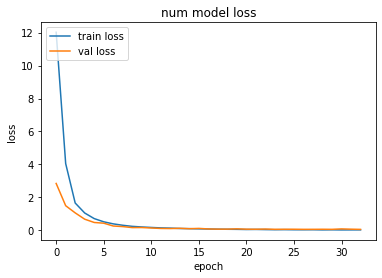

In [ ]:
plt.plot(history_conv_nums.history['loss'])
plt.plot(history_conv_nums.history['val_loss'])
plt.title('num model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

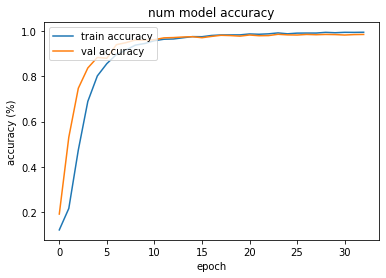

In [ ]:
plt.plot(history_conv_nums.history['acc'])
plt.plot(history_conv_nums.history['val_acc'])
plt.title('num model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

[[[146]
  [147]
  [145]
  [151]
  [159]
  [160]
  [156]
  [157]
  [163]
  [159]
  [157]
  [154]
  [165]
  [167]
  [164]
  [154]
  [153]
  [154]
  [150]
  [150]
  [150]
  [154]]

 [[157]
  [156]
  [156]
  [156]
  [158]
  [163]
  [160]
  [160]
  [164]
  [166]
  [165]
  [166]
  [170]
  [169]
  [171]
  [165]
  [165]
  [164]
  [166]
  [165]
  [168]
  [169]]

 [[167]
  [168]
  [168]
  [166]
  [168]
  [170]
  [170]
  [168]
  [166]
  [171]
  [167]
  [171]
  [171]
  [172]
  [173]
  [172]
  [173]
  [173]
  [174]
  [172]
  [171]
  [171]]

 [[170]
  [169]
  [171]
  [170]
  [167]
  [164]
  [163]
  [159]
  [162]
  [167]
  [170]
  [171]
  [171]
  [177]
  [175]
  [174]
  [174]
  [175]
  [175]
  [175]
  [176]
  [174]]

 [[175]
  [175]
  [172]
  [172]
  [170]
  [166]
  [162]
  [151]
  [136]
  [125]
  [119]
  [116]
  [128]
  [145]
  [163]
  [171]
  [173]
  [177]
  [175]
  [175]
  [175]
  [175]]

 [[176]
  [175]
  [176]
  [175]
  [175]
  [175]
  [171]
  [171]
  [166]
  [153]
  [136]
  [115]
  [100]
  [ 94

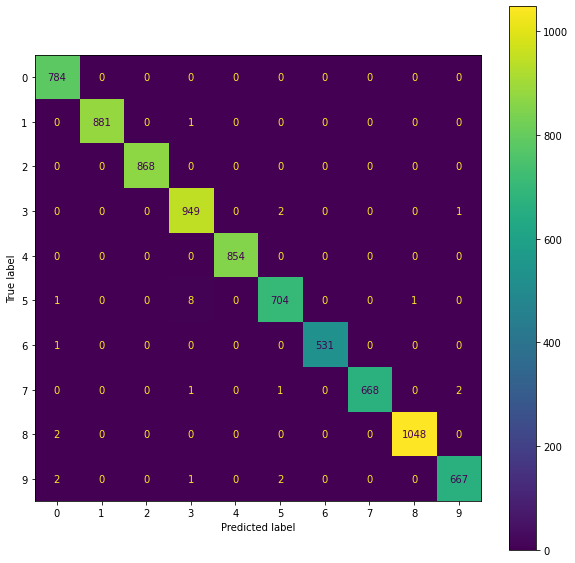

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
characters = "0123456789"
true = numEncodeArray2
true_num = [characters[np.argmax(i)] for i in true]

predicted = num_model.predict(numArray2)
predicted_num = [characters[np.argmax(i)] for i in predicted]

print(numArray2[0])


cm = confusion_matrix(true_num, predicted_num, labels=list(characters))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(characters))


fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()

In [ ]:
num_model.save('num_nn')

In [ ]:
# bits of pieces of code needed for integration into simulation
img_aug = np.expand_dims(img, axis=0)
y_predict = conv_model.predict(img_aug)[0]

predicted = num_model.predict(numArray2)
predicted_num = [characters[np.argmax(i)] for i in predicted]

print(predicted[0])
print(predicted_num[0])

characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
true = charEncodeArray
true_char = [characters[np.argmax(i)] for i in true]

predicted = char_model.predict(charArray)
predicted_char = [characters[np.argmax(i)] for i in predicted]

print(predicted[1])
print(predicted_char[1])

# now just need to find how to properly save